# Conversion Rate

### Objective 

We have a hypothetical source of ecommerce data about people who buy things from our site and people that don't buy things from our site.

Analyzing this data allows us to understand more clearly what is working and what isn't working for us.  Then we can either scale what's working and/or fix what isn't.

What we are going to do with this data is ultimately build a model that predicts the conversion rate and end up with recommendations for improving revenue.

<u>Data on our users includes:</u>
* Whether they converted or not 
* As well as some of their characteristics such as 
    * Their country
    * The marketing channel
    * Their age
    * Whether they are repeat users 
    * The number of pages visited during that session (as a proxy for site activity/time spent on site).

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
import itertools
from sklearn.utils import shuffle
# import tpot
%config InlineBackend.figure_format = 'png' 
%matplotlib inline
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

### Load Data

In [57]:
df = pd.read_csv('../data/conversion_data.csv')

### Preprocess Data

In [58]:
print "Rows: %r, Columns: %r "%(df.shape[0],df.shape[1])
print list(set(df.columns))

Rows: 316200, Columns: 6 
['new_user', 'country', 'age', 'total_pages_visited', 'source', 'converted']


In [59]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Notes:
* The user base is pretty young, with almost 4/5 being below 35.
    * Max age of 123 is a red flag.  Doesn't seem likely.  We'll investigate that further.
* 68% of users logged are new users.
* The average user spends their time viewing between 4-5 pages.
* The conversion rate at 3% seems pretty normal, as it's the industry standard


In [60]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [61]:
categorical_vars = ['country','source']

In [62]:
def plot_variables(variable_list = categorical_vars, file_location='../figures/categorical_vars.png'):
    for i,j in itertools.izip_longest(variable_list,range(len(variable_list))): # itertools.zip_longest for to execute the longest loop
        plt.subplot(np.ceil(len(variable_list)/2),2,j+1)
        plt.subplots_adjust(hspace=.5)
        sns.countplot(x=i,data = df)
        plt.xticks(rotation=90)
        plt.title(str("No. of Users by "+i.title()))
        # Get current axis on current figure
        ax = plt.gca()

        # Iterate through the list of axes' patches
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                    fontsize=12, color='black', ha='center', va='bottom')
    plt.savefig(file_location)

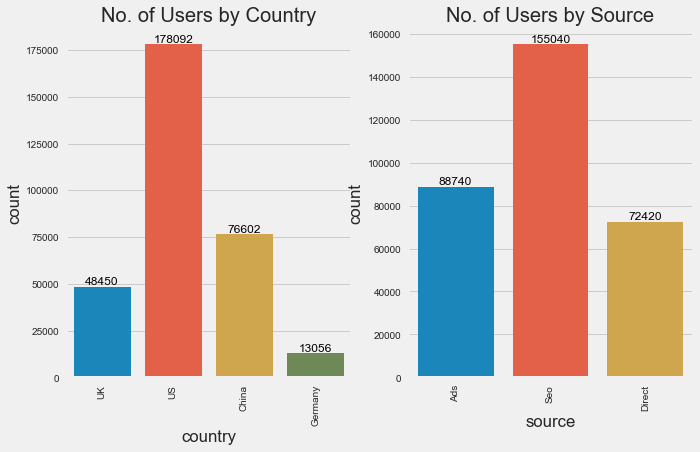

In [63]:
plot_variables(variable_list = categorical_vars, file_location='../figures/categorical_vars.png')

Notes:
  * We've got a US based site it looks like, although there's a large user base in china and a fair amount in uk too.
  * About half of the people visiting are coming in from SEO channels 

In [64]:
df.select_dtypes(include=[np.number]).head()

,age,new_user,total_pages_visited,converted
0,25,1,1,0
1,23,1,5,0
2,28,1,4,0
3,39,1,5,0
4,30,1,6,0


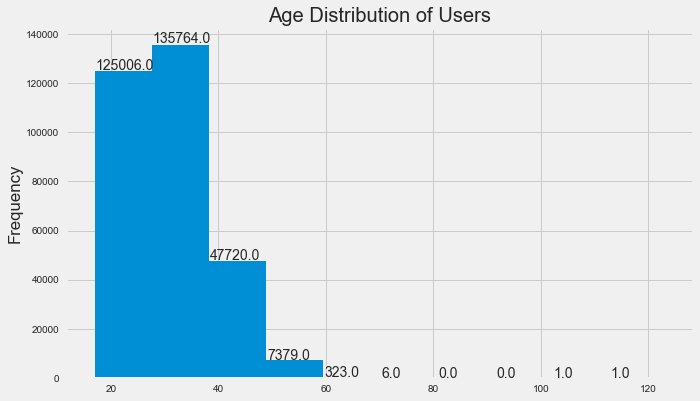

In [65]:
ax = df.age.plot(kind = 'hist', title = 'Age Distribution of Users')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/age_distribution_of_users.png')

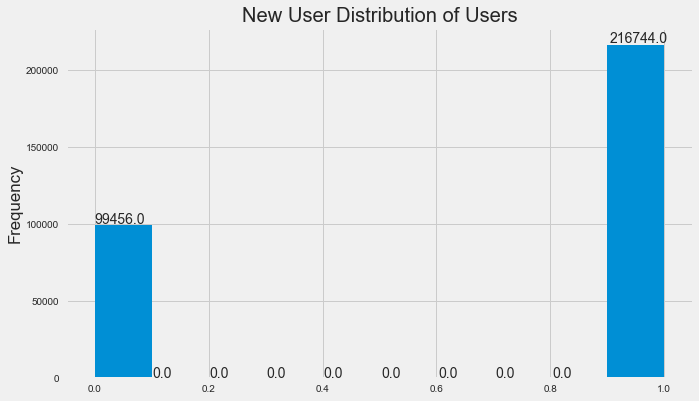

In [66]:
ax = df.new_user.plot(kind = 'hist', title = 'New User Distribution of Users')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/age_distribution_of_new_users.png')

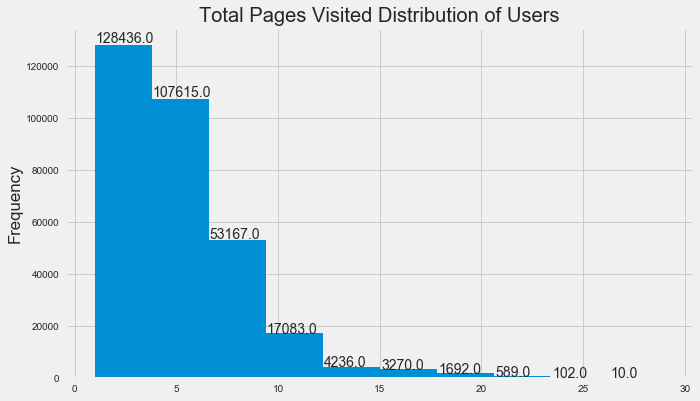

In [67]:
ax = df.total_pages_visited.plot(kind = 'hist', title = 'Total Pages Visited Distribution of Users')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.savefig('../figures/total_pages_visited_distribution_of_users.png')

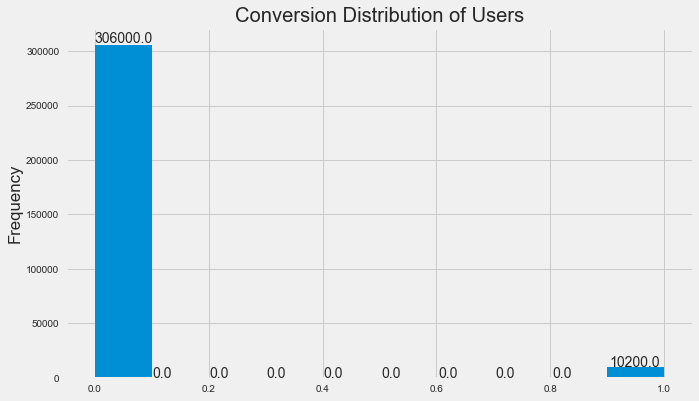

In [68]:
ax = df.converted.plot(kind = 'hist', title = 'Conversion Distribution of Users')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/conversion_distribution_of_users.png')

From this plot it really looks like we've got ourselves a very unbalanced set, but we should still be able to discern a lot about what works and what doesn't for converting users

### Handling Odd Data

Remember earlier when we looked at the age distribution, we saw that there were some weird values, mainly 123.

Let's see if there are others as well and if so let's remove them

In [69]:
#### Age Outliers ####
df[df.age > (df.age.mean()+(2*df.age.std()))].sort_values(by = 'age', ascending = False)[:5]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0


Yea it looks abnormal.  

Wrong data is worrisome and can be an indicator of a larger problem or bug in the code.  

For now, we'll remove it, but if this company were real I'd want to talk to the software engineer who owns the project / wrote the code and see how far it goes.

Chances are that it's user error, which is why we're removing them, but I'd feel better after investigating further.

In [70]:
df = df[df.age < 79]

### Explore Data Part 2

In [71]:
df.groupby('country').mean()['converted']
# df.columns

country
China      0.001332
Germany    0.062428
UK         0.052612
US         0.037801
Name: converted, dtype: float64

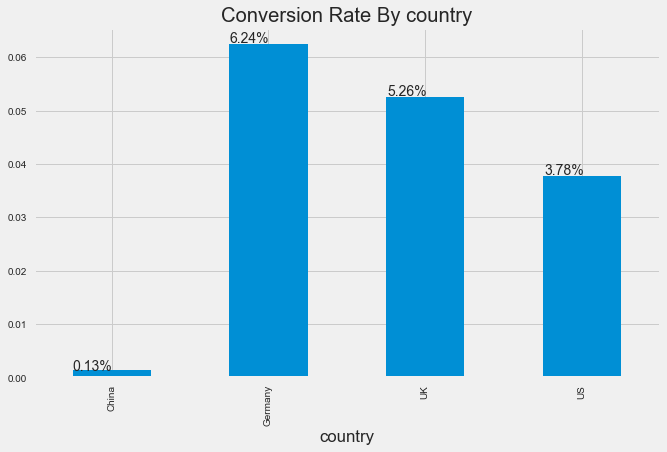

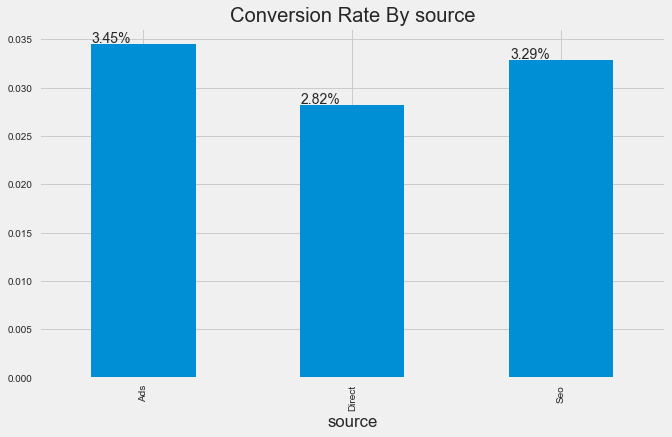

In [72]:
for var in categorical_vars:
    ax = df.groupby(var).mean()['converted'].plot(kind='bar',title = 'Conversion Rate By '+str(var))
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height()*100,2))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    plt.savefig('../figures/conversion_rate_by_'+var+'.png')

Notes:
    * Couple things here, China is not converting at all, despite have the second highest user base
    * Ads convert the best followed closely by SEO

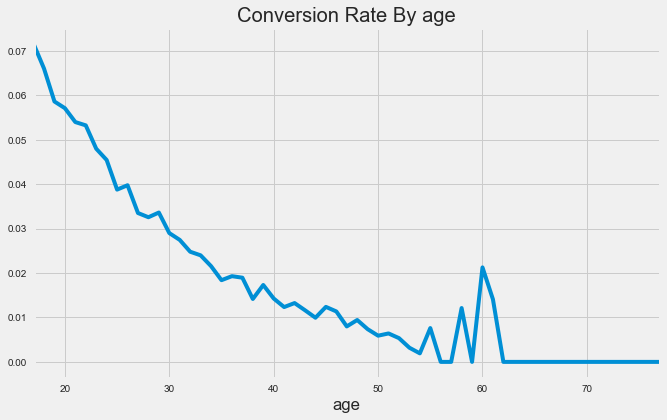

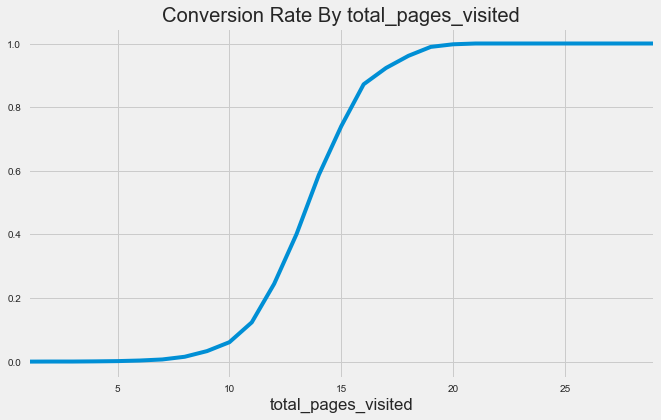

In [73]:
# for var in df[df.columns.difference(categorical_vars)]:
for var in df[['age','total_pages_visited']]:
    ax = df.groupby(var).mean()['converted'].plot(kind='line',title = 'Conversion Rate By '+str(var))
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height()*100,2))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    plt.savefig('../figures/total_pages_visited_distribution_of_users.png')

Notes:
  * From these graphs we can see that spending more time on the site implies higher probability of conversion
  * We can also see that age is inversely proportional to probability of conversion until ~55

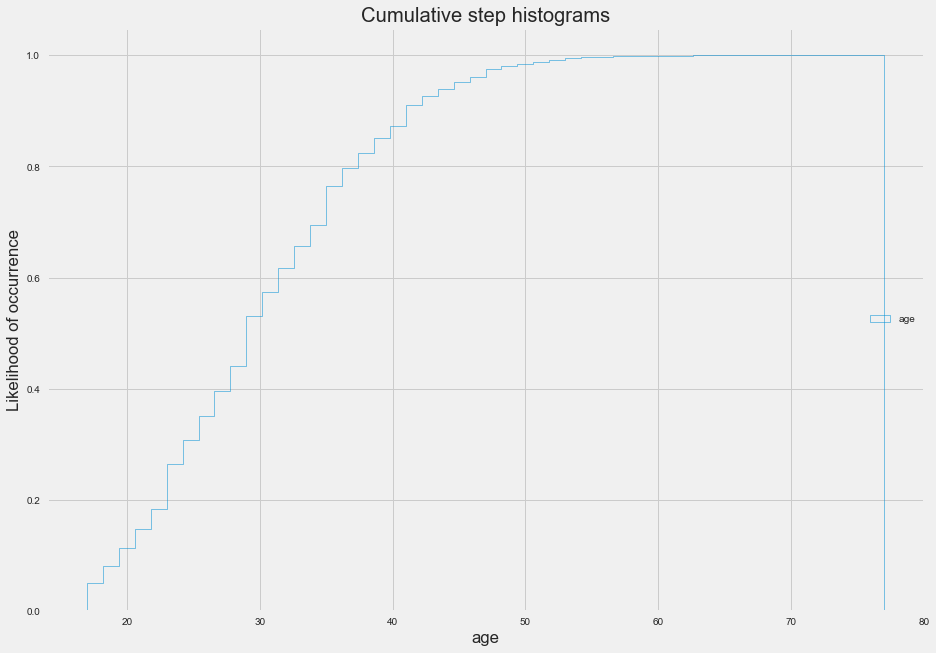

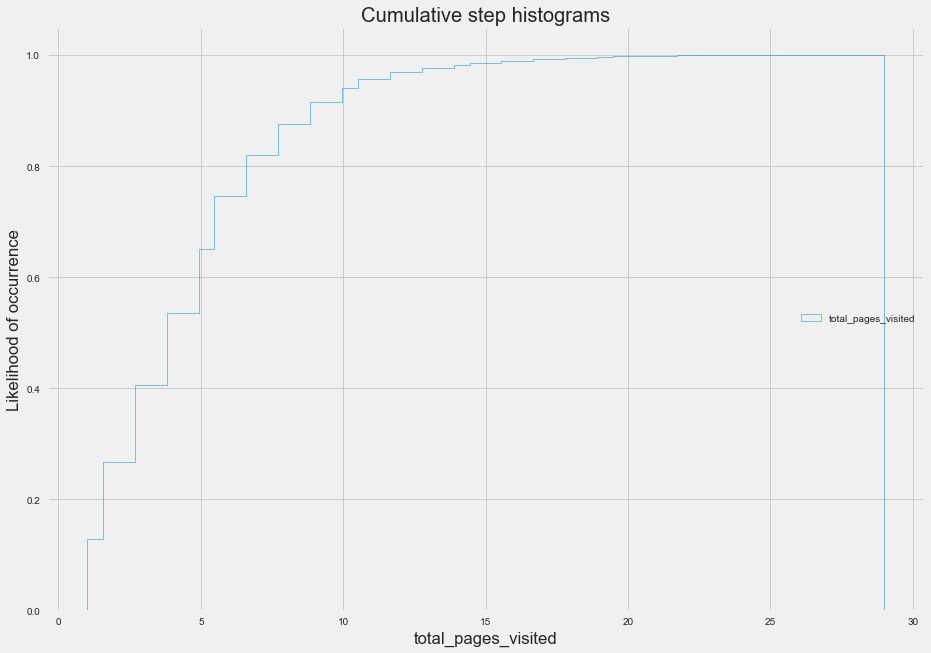

In [74]:
for var in df[['age','total_pages_visited']]:
    plt.suptitle("Cumulative Distribution Function - "+str(var))

    data = df[var]

    mu = 200
    sigma = 25
    n_bins = 50
    x = data

    fig, ax = plt.subplots(figsize=(14, 10))

    # plot the cumulative histogram
    n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                               cumulative=True)
    # tidy up the figure
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_title('Cumulative step histograms')
    ax.set_xlabel(str(var))
    ax.set_ylabel('Likelihood of occurrence')

    plt.show()

Cumulative Distribution plots show how many users are less than or equal to a specific variable

* So, for total_pages_visited, 60% of users have less than 5 pages visited

### Model Building

* Let’s now build a model to predict conversion rate. 
* Hopefully by the end we'll be able to give insights to our product / marketing teams 


#### Random Forest
* Let's give an RF model a try. Random Forests are good because you can usually optimize the algorithm pretty quickly.  It's also pretty good with outliers, and finding important variables.  
* We're going to use the RF to predict conversion and then use it's partial dependence plots and variable feature importances to see how our model go information from the variables and which variables are the best for predicting.
* Also, we're able to build and see the tree which we can then use to find our most obvious user segments.  


In [78]:
df = df.reset_index()

In [79]:
country = pd.get_dummies(df.set_index('index')['country']) 
source = pd.get_dummies(df.set_index('index')['source']) 
df = pd.merge(df, country.reset_index(), on='index')
df = pd.merge(df, source.reset_index(), on='index')


In [80]:
df = df.drop('index',axis = 1)
df = df.drop('source',axis = 1)
df = df.drop('country',axis = 1)

#### Shuffle, Split, CV

Create test/training set with a standard 66% split (if the data were too small, I would cross-validate) and
then build the forest with standard values for the 3 most important parameters (100 trees, trees as large as
possible, 3 random variables selected at each split)

In [36]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.patheffects as path_effects
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc


def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred = clf.predict(X)   
    if show_accuracy:
         print "F1:{0:.3f}".format(metrics.f1_score(y, y_pred)),"\n"
    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y, y_pred),"\n"    
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y, y_pred),"\n"

/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5]), <a list of 11 Text xticklabel objects>)

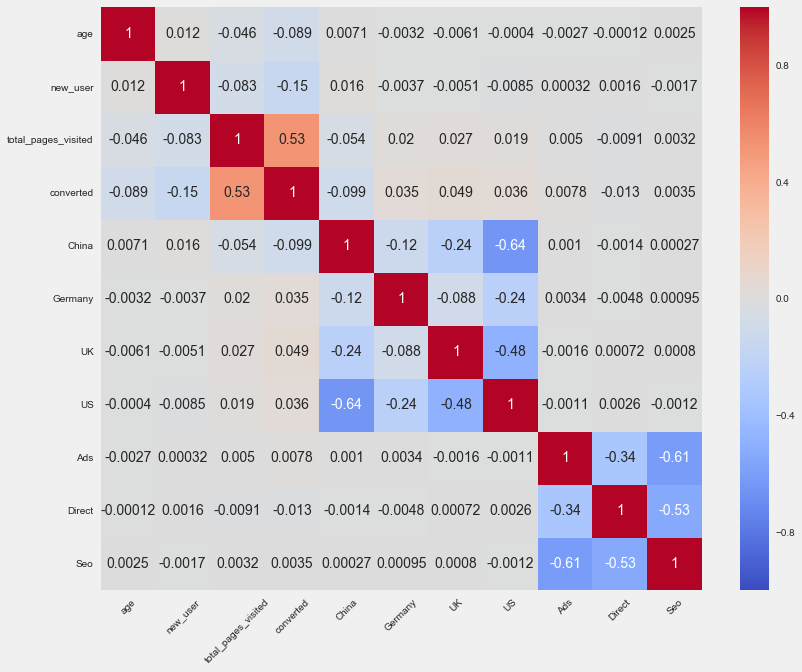

In [30]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,cbar=True,cmap="coolwarm")
plt.xticks(rotation=45)

In [43]:
print ("Baseline Accuracy: %r "%(1-df.converted.mean()))

Baseline Accuracy: 0.96774795459792473 


In [44]:
X = df.iloc[:,df.columns != "converted"]
y = df.iloc[:,df.columns=='converted']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

In [34]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
# X_test = clf.transform(X_test)
# measure_performance(X_test_fs, y_test, clf, show_confusion_matrix=False, show_classification_report=False)
measure_performance(X_test, y_test, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True)

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


F1:0.735 

Classification report
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     61283
          1       0.80      0.68      0.73      1957

avg / total       0.98      0.98      0.98     63240


Confusion matrix
[[60958   325]
 [  632  1325]] 



In [47]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape


(252957, 15)
(252957, 1)
(63240, 15)
(63240, 1)


In [48]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, \
                          labels = ['Left', 'Stayed']):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, fontsize = 12)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 12)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in range(0,width):
        for y in range(0,height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, \
                                foreground='black'), path_effects.Normal()])
    return

In [49]:
# These represent the y-intercept and coefficients for all the variables in the Random Forest.
def model_stats(model = RandomForestClassifier(), X_train = X_train, y_train = y_train, y_test = y_test, X_test = X_test):


    # 10-fold cross-validation for Random Forest to find the CV score
    mdl = model.fit(X_train, y_train)
    scores = cross_val_score(mdl, X_train, y_train, cv=10, scoring= 'accuracy')
    print("Mean CV Accuracy for Model: %r "% scores.mean())
    print()
    logit = model.predict(X_test)
    confusion = metrics.confusion_matrix(y_test, logit)
    print("Confusion Matrix for Model")
    print (confusion)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    # histogram of predicted probabilities of people leaving the company 
    plt.hist(y_pred_prob, bins=5)
    plt.xlim(0, 1)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    cm = confusion_matrix(y_test, logit)


    plot_confusion_matrix(cm, title='Model: Confusion Matrix', \
                          labels=['Stayed', 'Left'], cmap=plt.cm.Greens) 
    # Roc_curve for Our Model
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, logit)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1 (Converted)
    plt.figure(figsize=[5,5])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0, 1])
    plt.ylim([0, 1.5])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Model Receiver operating characteristic', fontsize=18)
    plt.legend(loc="upper left")
    plt.show()

Mean CV Accuracy for Model: 0.98416726569700219 
()
Confusion Matrix for Model
[[60961   322]
 [  626  1331]]


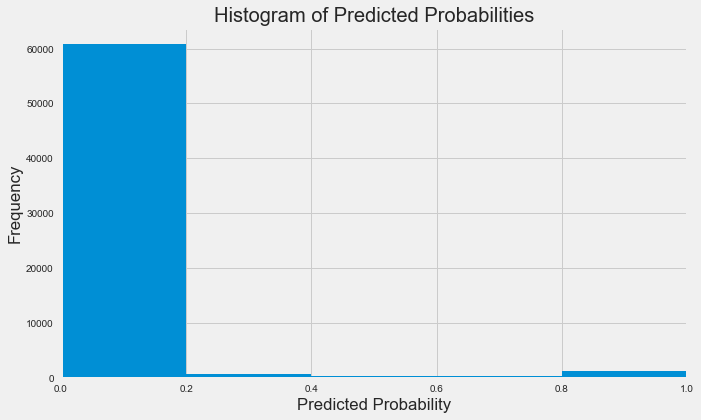

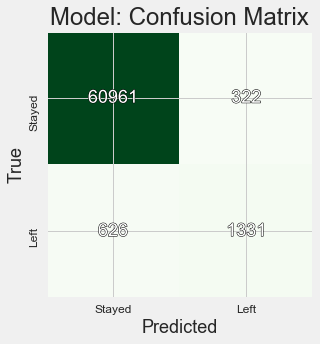

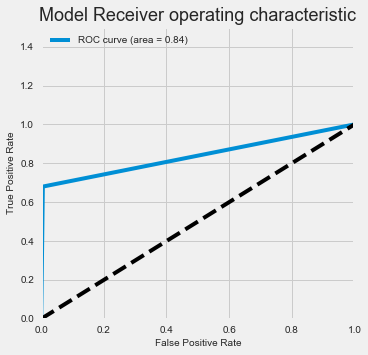

In [38]:
model_stats(model = RandomForestClassifier(), X_train = X_train, y_train = y_train.values.ravel(), y_test = y_test, X_test = X_test)

Since we started from a 97% accuracy (that’s the case if we classified everything as “non converted”), our 98.5% is good, but not mind blowing.

If we cared about the very best possible accuracy or specifically minimizing false positive/false negative,
we would also use ROCR and find the best cut-off point. If I had a bit more time, I'd most likely grid search and find which model gives us the best ROC curve.

Since in this case that doesn’t appear to be particularly relevant, we are fine with the default 0.5 cutoff value used internally by the random forest to make the prediction. 

Let's check out the insights we can find from this model

Feature ranking:
1. feature age (0.824864)
2. feature new_user (0.102668)
3. feature total_pages_visited (0.039585)
4. feature China (0.018959)
5. feature Germany (0.002750)
6. feature UK (0.002550)
7. feature US (0.002391)
8. feature Ads (0.002375)
9. feature Direct (0.002316)
10. feature Seo (0.001542)


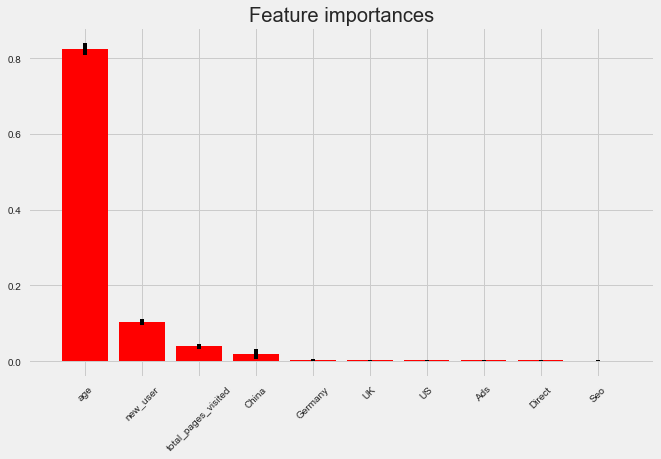

In [39]:
forest = clf
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print("%d. feature %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
plt.xticks(rotation=45)
plt.xticks(range(X.shape[1]), X.columns)
plt.xlim([-1, X.shape[1]])
plt.show()

### Random Forest with Weighted Classes

In [40]:
clf = RandomForestClassifier(class_weight = {1:.7, 0:.3}, oob_score = True)
clf.fit(X_train, y_train)
# X_test = clf.transform(X_test)
# measure_performance(X_test_fs, y_test, clf, show_confusion_matrix=False, show_classification_report=False)
measure_performance(X_test, y_test, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True)

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


F1:0.739 

Classification report
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     61283
          1       0.74      0.74      0.74      1957

avg / total       0.98      0.98      0.98     63240


Confusion matrix
[[60777   506]
 [  514  1443]] 



Feature ranking:
1. feature age (0.828039)
2. feature new_user (0.090987)
3. feature total_pages_visited (0.036650)
4. feature China (0.026504)
5. feature Germany (0.004571)
6. feature UK (0.003753)
7. feature US (0.002771)
8. feature Ads (0.002401)
9. feature Direct (0.002376)
10. feature Seo (0.001947)


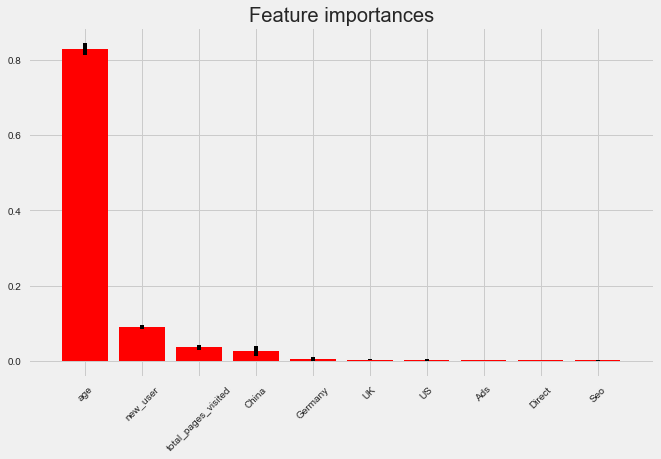

In [41]:
forest = clf
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print("%d. feature %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
plt.xticks(rotation=45)
plt.xticks(range(X.shape[1]), X.columns)
plt.xlim([-1, X.shape[1]])
plt.show()

In [42]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [43]:
from __future__ import print_function

import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [44]:
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best')

In [45]:
features = list(X.columns[:4])

In [46]:
visualize_tree(dt, X.columns)

### Let's compare model accuracies

In [47]:
important_features = ['age','new_user','total_pages_visited','china']
All_features = X.columns

In [48]:
Pred_var = ["converted"]

In [49]:
from sklearn.naive_bayes import GaussianNB as GB
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



In [50]:
def Classification_model(model,Data,x,y): # here x is the variable which are used for prediction
    # y is the prediction variable
    train,test = train_test_split(Data,test_size= 0.33)
    train_x = Data.ix[train.index,x] # Data for training only with features
    train_y = Data.ix[train.index,y] # Data for training only with predcition variable
    test_x = Data.ix[test.index,x] # same as for training 
    test_y = Data.ix[test.index,y]
    model.fit(train_x,train_y.values.ravel())
    pred=model.predict(test_x)
    accuracy=accuracy_score(test_y,pred)
    return accuracy

In [51]:
# Lets us make a list of models
models=["RandomForestClassifier","Gaussian Naive Bayes","Logistic_Regression","Support_Vector"]
Classification_models = [RandomForestClassifier(n_estimators=100),GB(),LogisticRegression(),SVC()]
Model_Accuracy = []
for model in Classification_models:
    Accuracy=Classification_model(model,df,All_features,Pred_var)
    Model_Accuracy.append(Accuracy)
    
Accuracy_with_all_features = pd.DataFrame(
    { "Classification Model" :models,
     "Accuracy with all features":Model_Accuracy
     
    })

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [52]:
Accuracy_with_all_features.sort_values(by="Accuracy with all features",ascending=False).reset_index(drop=True)

,Accuracy with all features,Classification Model
0,0.986296,Logistic_Regression
1,0.985692,Support_Vector
2,0.984417,RandomForestClassifier
3,0.963334,Gaussian Naive Bayes


### Conclusion

Some summary insights:
1. The site is working very well for young users, so we'll tell marketing to advertise and use marketing channels which are more likely to reach young people.
2. The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans.
3. Something is wrong with the Chinese version of the site.  There are countless reasons but we should be converting at a much higher rate.  Maybe check that our translated site works well, or that our design fits the way Chinese users use sites, etc.
4. Older people are not great users. Maybe go through the UI and figure out why older users perform so poorly?
5. If I know someone has visited many pages, but hasn’t converted, that person almost surely has high purchase intent. I could email her targeted offers or sending her reminders. Overall, these are probably the easiest users to make convert.  The numbers show it clearly.


### Improvements:

I think investigating the other classification models a further could lead to better results as well as adding grid search to each to find the best parameters.  Finally, We didn't scale or normalize the model, so doing so could lead to different and potentially improved results.